<a href="https://colab.research.google.com/github/kadilrahman/goodread_prediction-/blob/master/goodread_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview

My main task was to predict the rating of a random book, which I achieved by implementing the appropriate machine learning algorithms. I built three models: a Baseline Machine Learning Model where I used a Logistic Regression model, a 3-layer Neural Network Model, and a Deep Neural Network (DNN). For the Complex Neural Network, I used Long Short-Term Memory (LSTMs), which is a type of Recurrent Neural Network (RNN), Gated Recurrent Units (GRUs) which are again a type of Recurrent Neural Networks (RNN) used for modeling sequential data, and Bidirectional Encoder Representations from Transformers (BERT). BERT uses a bidirectional approach to generate contextualized word embeddings, which are representations of words that capture their meanings in the context of a sentence. This approach is beneficial because it is pre-trained on massive amounts of text data, allowing it to learn general language patterns and relationships between words.

In [ ]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train = pd.read_csv("/content/drive/MyDrive/my_goodreads_train.csv")
test = pd.read_csv("/content/drive/MyDrive/my_goodreads_test.csv")

In [ ]:
train.shape

(700000, 11)

In [ ]:
test.shape

(200000, 11)

# Method:

The data I initially received consists of two datasets, namely the training and testing datasets. Both datasets include 11 features: "#" which is the index, "user_id" that pertains to the unique identity of the user, "review_id" representing the ID of the review, "rating" which is the review of the book on a scale of 1 to 5, "review_text" that represents the content of the review, "date_added" showing when the review was added, "date_updated" indicating when the review was last updated, "read_at" representing the date and time the book was read, "started_at" showing when the user started reading the book, "n_votes" representing the number of votes the review received, and "n_comments" indicating the number of comments on the review.

Moving forward, I began exploring the dataset and preprocessing it by checking for any missing or null values, which I then removed from the dataset.

In [ ]:
train['rating'].unique()

array([5, 4, 3, 2, 1])

In [ ]:
train['n_votes'].unique()

In [ ]:
train['n_comments'].unique()

In [ ]:
train.columns

Index(['user_id', 'book_id', 'review_id', 'rating', 'review_text',
       'date_added', 'date_updated', 'read_at', 'started_at', 'n_votes',
       'n_comments'],
      dtype='object')

In [ ]:
len(train['book_id'].unique())

25469

In [ ]:
len(test['book_id'].unique())

24074

In [ ]:
entire_bookid_list = pd.concat((train['book_id'], test['book_id'])).reset_index(drop=True).unique()
len(entire_bookid_list)

25474

In [ ]:
train.isna().sum()

user_id              0
book_id              0
review_id            0
rating               0
review_text          0
date_added           0
date_updated         0
read_at          71412
started_at      213411
n_votes              0
n_comments           0
dtype: int64

In [ ]:
test.isna().sum()

Unnamed: 0          0
user_id             0
book_id             0
review_id           0
review_text         0
date_added          0
date_updated        0
read_at         20354
started_at      60886
n_votes             0
n_comments          0
dtype: int64

In [ ]:
##Checking Users' behaviour If some users reviewed too many books and if the users reviewed the same books more than once

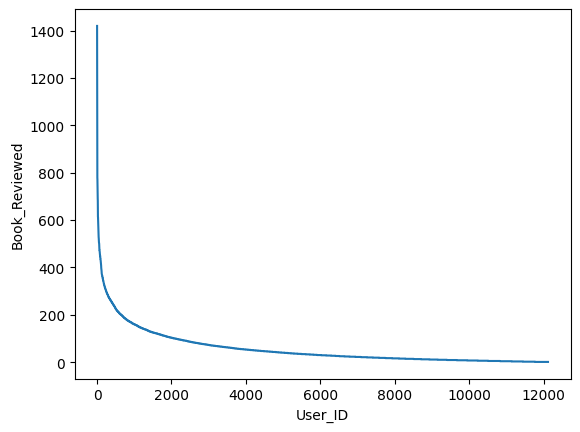

In [ ]:
# setting default matplotlib plot style
import matplotlib as mpl
dist_user_reviews = sorted(list(train.user_id.value_counts().items()),key = lambda x: -x[1])

default_params = mpl.rcParamsDefault
mpl.rcParams.update(default_params)

# conclusion: power law of a few users with lots of reviews
plt.plot([x[1] for x in dist_user_reviews])
plt.ylabel('Book_Reviewed')
plt.xlabel('User_ID')
plt.show()

In [ ]:
book_per_user = train.groupby(['user_id', 'book_id']).count()['review_id']
book_per_user

user_id                            book_id  
10006c00c7d34cd88f2aac4d6ffa6a645  166417571    1
1000adc590342f0cb89bd397ef8387ede  186742       1
                                   11558606     1
                                   13411266     1
                                   15011367     1
                                               ..
1ffeb2fdedaded45fa3756de1a4ad0380  196712231    1
                                   198374371    1
1fffb57b45549698bea9af95135cf83f4  11764        1
                                   178712       1
                                   195092       1
Name: review_id, Length: 700000, dtype: int64

In [ ]:
# nobody review of the same book
book_per_user.max()

1

In [ ]:
##Checking Reviews per Book

In [ ]:
train['n_review_per_book'] = train.groupby('book_id')['book_id'].transform(len)

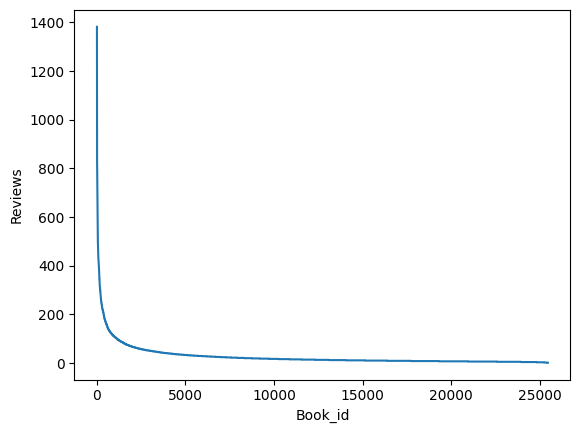

In [ ]:
# There are a lot of reviews for some books
reviews_x_book = [x[1] for x in sorted(list(set([(x, y) for x, y in train[['book_id', 'n_review_per_book']].values])),
                                       key = lambda x: -x[1])]

plt.plot(reviews_x_book)
plt.ylabel('Reviews')
plt.xlabel('Book_id')
plt.show()

In [ ]:
train=train[['book_id','review_text','n_votes','n_comments','rating']]
train

,book_id,review_text,n_votes,n_comments,rating
0,182091851,I thought this was a very good historical fant...,5,6,5
1,1451461,I've had this book recommended to me more than...,0,0,5
2,13483572,Seriously! You go and throw that twist into th...,0,0,5
3,131585171,Gosh!!! I'm still not recovering from the effi...,5,0,4
4,195643271,"3.5 stars rounded down. I can't help it, I jus...",0,0,3
...,...,...,...,...,...
699995,137889043,Beauty of the Beast is a slow-burn romance tha...,0,0,4
699996,18920506,I absolutely hate cliffhangers! \n Dreamfever ...,0,0,5
699997,144000061,Actual rating: 4.5,2,0,5
699998,163023491,** spoiler alert ** \n 4.0/5 \n Predictable. \...,0,0,4


# Clean review_text

I cleaned the review text and removed the noise caused by abundant punctuations, wide spaces, and invalid characters, which would otherwise have been responsible for the inefficiency in executing the algorithms I used. It's vital to get rid of unnecessary input values and classify nouns, pronouns, and verbs.

I split the data into training, testing, and validation according to the best fit and kept it consistent to avoid void/inefficient results and achieve optimum efficiency.

In [ ]:
!pip install neattext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install swifter

In [ ]:
import neattext as nt
import neattext.functions as nfx

In [ ]:
train['review_text']

0         I thought this was a very good historical fant...
1         I've had this book recommended to me more than...
2         Seriously! You go and throw that twist into th...
3         Gosh!!! I'm still not recovering from the effi...
4         3.5 stars rounded down. I can't help it, I jus...
                                ...                        
699995    Beauty of the Beast is a slow-burn romance tha...
699996    I absolutely hate cliffhangers! \n Dreamfever ...
699997                                   Actual rating: 4.5
699998    ** spoiler alert ** \n 4.0/5 \n Predictable. \...
699999    What a fantastic novel. I am not a gamer (the ...
Name: review_text, Length: 700000, dtype: object

In [ ]:
word_train=train['review_text'].str.lower()
word_train

In [ ]:
word_train_noise=word_train.apply(lambda x: nt.TextFrame(x).noise_scan()['text_noise'])# Noise Scan
word_train_noise

In [ ]:
del word_train_noise

In [ ]:
train['review_text_clean']=word_train.apply(lambda x:nfx.remove_custom_pattern(x,term_pattern=r'$&\+'))#removing urls
train['review_text_clean']

In [ ]:
train['review_text_clean']=train['review_text_clean'].apply(lambda x:nfx.remove_custom_pattern(x,term_pattern=r'\n'))#removing new line characters
train['review_text_clean']

In [ ]:
train['review_text_clean']=train['review_text_clean'].apply(nfx.remove_special_characters)#removing special charachters
train['review_text_clean']

In [ ]:
train['review_text_clean']=train['review_text_clean'].apply(nfx.remove_multiple_spaces)#removing multiple spaces
train['review_text_clean']

In [ ]:
train['review_text_clean']=train['review_text_clean'].apply(nfx.remove_stopwords)#removing stopwords
train['review_text_clean']

0         thought good historical fantasy set new york c...
1         ive book recommended decided shot turns pretty...
2         seriously throw twist story kills love series ...
3         gosh im recovering effing cliffhanger book way...
4         35 stars rounded cant help dont connect theo p...
                                ...                        
699995    beauty beast slowburn romance features descrip...
699996    absolutely hate cliffhangers dreamfever sucked...
699997                                     actual rating 45
699998    spoiler alert 405 predictable im sorry kind tr...
699999    fantastic novel gamer game ive actually played...
Name: review_text_clean, Length: 700000, dtype: object

In [ ]:
Double_check_noise=train['review_text_clean'].apply(lambda x: nt.TextFrame(x).noise_scan()['text_noise'])#Double check noise
Double_check_noise

0         0
1         0
2         0
3         0
4         0
         ..
699995    0
699996    0
699997    0
699998    0
699999    0
Name: review_text_clean, Length: 700000, dtype: int64

In [ ]:
del Double_check_noise

In [ ]:
idx_duplicated = train.loc[train.review_text_clean.duplicated()].index
print(f'Duplicates removed: {len(idx_duplicated)}')
train.drop(index = idx_duplicated, inplace = True)
del idx_duplicated

Duplicates removed: 12565


In [ ]:
idx_selfref = [(idx) for idx, row in train.iterrows() if ('review' in row.review_text_clean)]
print(f'Self-referencing reviews removed: {len(idx_selfref)}')
train.drop(index = idx_selfref, inplace = True)
del idx_selfref

Self-referencing reviews removed: 125568


In [ ]:
#Checking avg and max length of reviews

In [ ]:
review_length = train.review_text_clean.transform(len)

In [ ]:
min_revlen = review_length.min()
min_revlen

0

In [ ]:
del min_revlen

In [ ]:
mean_revlen = review_length.mean()
mean_revlen

472.9166955881018

In [ ]:
del mean_revlen

In [ ]:
median_revlen = review_length.median()
median_revlen

275.0

In [ ]:
del median_revlen

In [ ]:
max_revlen = review_length.max()
max_revlen

10595

In [ ]:
del max_revlen

In [ ]:
#Dropping too short and too long reviews At least they should be contained between the median and 90th percentile

In [ ]:
fiftieth_percentile = review_length.quantile(0.50)
fiftieth_percentile

275.0

In [ ]:
ninetieth_percentile = review_length.quantile(0.90)
ninetieth_percentile

1167.0

In [ ]:
greater_than_fiftieth = review_length.values > fiftieth_percentile
lower_than_last = review_length.values < ninetieth_percentile

In [ ]:
indices = [train.index[x] for x in np.where(greater_than_fiftieth & lower_than_last)[0]]

In [ ]:
train = train.loc[indices]
train_len = len(train)
print(f'New Dataset Length: {train_len}')

New Dataset Length: 224278


In [ ]:
train["review_text_clean"]

0         thought good historical fantasy set new york c...
4         35 stars rounded cant help dont connect theo p...
5         read wasp factory scottish literature class ye...
7         unexpected read venture world contemporary rom...
8         dnf 49 dont know expecting bookmaybe dealing s...
                                ...                        
699986    good book hmm slightly picked deliciously chee...
699992    interesting look alternate timeline superman l...
699993    series interesting classic alice wonderland st...
699998    spoiler alert 405 predictable im sorry kind tr...
699999    fantastic novel gamer game ive actually played...
Name: review_text_clean, Length: 224278, dtype: object

In [ ]:
rev_train = train[["review_text_clean", "rating", "book_id","n_votes","n_comments"]]
del train

In [ ]:
rev_train.head()

,review_text_clean,rating,book_id,n_votes,n_comments
0,thought good historical fantasy set new york c...,5,182091851,5,6
4,35 stars rounded cant help dont connect theo p...,3,195643271,0,0
5,read wasp factory scottish literature class ye...,2,1876765,0,0
7,unexpected read venture world contemporary rom...,5,100833271,0,0
8,dnf 49 dont know expecting bookmaybe dealing s...,1,133218621,0,0


In [ ]:
len(rev_train)

224278

In [ ]:
###Tokeninzing the Text

In [ ]:
%%capture
pip install --user -U nltk

In [ ]:
%%capture
!pip install swifter

In [ ]:
import swifter
import nltk
nltk.download('punkt')
from nltk import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
rev_train["tokenized_text"] = rev_train.review_text_clean.swifter.apply(lambda x: word_tokenize(x))
rev_train.head()

Pandas Apply:   0%|          | 0/224278 [00:00<?, ?it/s]

,review_text_clean,rating,book_id,n_votes,n_comments,tokenized_text
0,thought good historical fantasy set new york c...,5,182091851,5,6,"[thought, good, historical, fantasy, set, new,..."
4,35 stars rounded cant help dont connect theo p...,3,195643271,0,0,"[35, stars, rounded, cant, help, dont, connect..."
5,read wasp factory scottish literature class ye...,2,1876765,0,0,"[read, wasp, factory, scottish, literature, cl..."
7,unexpected read venture world contemporary rom...,5,100833271,0,0,"[unexpected, read, venture, world, contemporar..."
8,dnf 49 dont know expecting bookmaybe dealing s...,1,133218621,0,0,"[dnf, 49, dont, know, expecting, bookmaybe, de..."


In [ ]:
##POS tagging The Part Of Speech tag. Valid options are "n" for nouns, "v" for verbs, "a" for adjectives, "r" for adverbs and "s" for satellite adjectives.

In [ ]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
from nltk.corpus import wordnet
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [ ]:
rev_train["postagged_text"] = rev_train.tokenized_text.swifter.apply(lambda x: nltk.pos_tag(x))

Pandas Apply:   0%|          | 0/224278 [00:00<?, ?it/s]

In [ ]:
rev_train.drop('tokenized_text', axis = 1, inplace = True)
list_of_tags = rev_train.postagged_text.swifter.apply(lambda x: [el[1] for el in x if len(el) == 2]).tolist()
set_of_tags = set()

for ls in list_of_tags:
    for tag in ls:
        set_of_tags.add(tag)

Pandas Apply:   0%|          | 0/224278 [00:00<?, ?it/s]

In [ ]:
from nltk.corpus import wordnet
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
pos_mapper = {k : get_wordnet_pos(k) for k in set_of_tags}

In [ ]:
list(pos_mapper.items())[:5]

[('RBS', 'r'), ('DT', None), ('VBG', 'v'), ('NNS', 'n'), ('$', None)]

In [ ]:
rev_train.head()

,review_text_clean,rating,book_id,n_votes,n_comments,postagged_text
0,thought good historical fantasy set new york c...,5,182091851,5,6,"[(thought, RB), (good, JJ), (historical, JJ), ..."
4,35 stars rounded cant help dont connect theo p...,3,195643271,0,0,"[(35, CD), (stars, NNS), (rounded, VBD), (cant..."
5,read wasp factory scottish literature class ye...,2,1876765,0,0,"[(read, VB), (wasp, JJ), (factory, JJ), (scott..."
7,unexpected read venture world contemporary rom...,5,100833271,0,0,"[(unexpected, JJ), (read, JJ), (venture, NN), ..."
8,dnf 49 dont know expecting bookmaybe dealing s...,1,133218621,0,0,"[(dnf, NN), (49, CD), (dont, NN), (know, VBP),..."


In [ ]:
# minimum length of the remaining words of the fixed tokenized text
print('Minimum Length of a Word in the Dataset:', end=' ')
min([min(x) for x in rev_train.postagged_text.map(lambda x: ([len(el[0]) for el in x])) if x != []])

Minimum Length of a Word in the Dataset: 

1

In [ ]:
#filtering the words with a length less than 2
rev_train["postagged_text"] = rev_train.postagged_text.map(lambda x: [el for el in x if len(el[0]) > 2])

In [ ]:
# minimum length of the remaining words of the fixed tokenized text after update
print('Minimum Length of a Word in the Dataset:', end=' ')
min([min(x) for x in rev_train.postagged_text.map(lambda x: ([len(el[0]) for el in x])) if x != []])

Minimum Length of a Word in the Dataset: 

3

In [ ]:
###Lemmatize the Tokens

In [ ]:
from nltk.stem.wordnet import WordNetLemmatizer
def lemmatize_row(row):
    lemmatizer = WordNetLemmatizer()
    lemmatized_row = list()

    for token, pos in row:
        if pos_mapper[pos] is None:
            lemma = lemmatizer.lemmatize(token)
        else:
            lemma = lemmatizer.lemmatize(token, pos = pos_mapper[pos])

        lemmatized_row.append(lemma) # we discarded the pos here

    return lemmatized_row

In [ ]:
#lemmatizing
rev_train['lemmatized_text'] = rev_train.postagged_text.swifter.apply(lambda x: lemmatize_row(x))

Pandas Apply:   0%|          | 0/224278 [00:00<?, ?it/s]

In [ ]:
rev_train.drop('postagged_text', axis = 1, inplace = True)

In [ ]:
rev_train.head()

,review_text_clean,rating,book_id,n_votes,n_comments,lemmatized_text
0,thought good historical fantasy set new york c...,5,182091851,5,6,"[thought, good, historical, fantasy, set, new,..."
4,35 stars rounded cant help dont connect theo p...,3,195643271,0,0,"[star, round, cant, help, dont, connect, theo,..."
5,read wasp factory scottish literature class ye...,2,1876765,0,0,"[read, wasp, factory, scottish, literature, cl..."
7,unexpected read venture world contemporary rom...,5,100833271,0,0,"[unexpected, read, venture, world, contemporar..."
8,dnf 49 dont know expecting bookmaybe dealing s...,1,133218621,0,0,"[dnf, dont, know, expect, bookmaybe, deal, sup..."


In [ ]:
rev_train.shape

(224278, 6)

# Saving the Training Set

In [ ]:
rev_train.to_csv('/content/drive/MyDrive/Dataset/training_set_preprocessed.csv', index = False)

In [ ]:
del rev_train

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Dataset/training_set_preprocessed.csv')

In [ ]:
train= train.astype("str")

In [ ]:
train.to_csv('/content/drive/MyDrive/Dataset/training_set_preprocessed_str.csv', index = False)

In [ ]:
del train

# Deal Test dataset

In [ ]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
test = pd.read_csv("/content/drive/MyDrive/Dataset/my_goodreads_test.csv")

In [ ]:
test.shape

In [ ]:
test.head()

In [ ]:
test['review_text']

In [ ]:
word_test=test['review_text'].str.lower()

In [ ]:
import neattext as nt
import neattext.functions as nfx

In [ ]:
Noise_Scan_test=word_test.apply(lambda x: nt.TextFrame(x).noise_scan()['text_noise'])# Noise Scan

In [ ]:
Noise_Scan_test

In [ ]:
del Noise_Scan_test

In [ ]:
test['review_text_clean']=word_test.apply(lambda x:nfx.remove_custom_pattern(x,term_pattern=r'$&\+'))#removing urls
test['review_text_clean']=test['review_text_clean'].apply(lambda x:nfx.remove_custom_pattern(x,term_pattern=r'\n'))#removing new line characters
test['review_text_clean']=test['review_text_clean'].apply(nfx.remove_special_characters)#removing special charachters
test['review_text_clean']=test['review_text_clean'].apply(nfx.remove_multiple_spaces)#removing multiple spaces
test['review_text_clean']=test['review_text_clean'].apply(nfx.remove_stopwords)

In [ ]:
test['review_text_clean'].apply(lambda x: nt.TextFrame(x).noise_scan()['text_noise'])#check noise

In [ ]:
test['review_text_clean']

In [ ]:
rev_test = test[["review_id","review_text_clean", "book_id","n_votes","n_comments"]]
del test

In [ ]:
len(rev_test)

In [ ]:
import swifter
import nltk
from nltk import word_tokenize
rev_test["tokenized_text"] = rev_test.review_text_clean.swifter.apply(lambda x: word_tokenize(x))

In [ ]:
nltk.download('averaged_perceptron_tagger')

In [ ]:
from nltk.corpus import wordnet
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

In [ ]:
def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [ ]:
rev_test["postagged_text"] = rev_test.tokenized_text.swifter.apply(lambda x: nltk.pos_tag(x))

In [ ]:
rev_test["postagged_text"].shape

In [ ]:
rev_test.drop('tokenized_text', axis = 1, inplace = True)
list_of_tags = rev_test.postagged_text.swifter.apply(lambda x: [el[1] for el in x if len(el) == 2]).tolist()
set_of_tags = set()

for ls in list_of_tags:
    for tag in ls:
        set_of_tags.add(tag)

In [ ]:
pos_mapper_test = {k : get_wordnet_pos(k) for k in set_of_tags}

In [ ]:
list(pos_mapper_test.items())[:5]

In [ ]:
rev_test.head()

In [ ]:
from nltk.corpus import wordnet
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

In [ ]:
# minimum length of the remaining words of the fixed tokenized text
print('Minimum Length of a Word in the Dataset:', end=' ')
min([min(x) for x in rev_test.postagged_text.map(lambda x: ([len(el[0]) for el in x])) if x != []])

In [ ]:
#filtering the words with a length less than 2
rev_test["postagged_text"] = rev_test.postagged_text.map(lambda x: [el for el in x if len(el[0]) > 2])

In [ ]:
# minimum length of the remaining words of the fixed tokenized text after update
print('Minimum Length of a Word in the Dataset:', end=' ')
min([min(x) for x in rev_test.postagged_text.map(lambda x: ([len(el[0]) for el in x])) if x != []])

In [ ]:
from nltk.stem.wordnet import WordNetLemmatizer
def lemmatize_row(row):
    lemmatizer = WordNetLemmatizer()
    lemmatized_row = list()

    for token, pos in row:
        if pos_mapper_test[pos] is None:
            lemma = lemmatizer.lemmatize(token)
        else:
            lemma = lemmatizer.lemmatize(token, pos = pos_mapper_test[pos])

        lemmatized_row.append(lemma) # we discarded the pos here

    return lemmatized_row

In [ ]:
#lemmatizing
rev_test['lemmatized_text'] = rev_test.postagged_text.swifter.apply(lambda x: lemmatize_row(x))

In [ ]:
rev_test['lemmatized_text'].shape

In [ ]:
rev_test.head()

In [ ]:
rev_test.drop('postagged_text', axis = 1, inplace = True)

In [ ]:
rev_test.to_csv('/content/drive/MyDrive/Dataset/testing_set_preprocessed.csv', index = False)

In [ ]:
del rev_test

In [ ]:
rev_test = pd.read_csv('/content/drive/MyDrive/Dataset/testing_set_preprocessed.csv')

In [ ]:
rev_test= rev_test.astype("str")

In [ ]:
rev_test.to_csv('/content/drive/MyDrive/Dataset/testing_set_preprocessed_str.csv', index = False)

In [ ]:
del rev_test

#Standard ML Baseline: Logistic regression

For my standard machine learning baseline model, I chose to use the Logistic Regression Model. It's a widely used statistical method for binary classification tasks, where the goal is to predict a binary outcome, such as whether a book is highly rated or not. I believe it can be a useful method for classification tasks, and its performance can be easily assessed using performance metrics like the F1 Score, among others.



In [ ]:
import pandas as pd
import re
import string
import nltk
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/Dataset/my_goodreads_train.csv")
test = pd.read_csv("/content/drive/MyDrive/Dataset/my_goodreads_test.csv")

In [ ]:
!pip install neattext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import neattext as nt
import neattext.functions as nfx

In [ ]:
#removing custom patterns like $&\+
train['review_text_clean']=train['review_text'].apply(lambda x:nfx.remove_custom_pattern(x,term_pattern=r'$&\+'))

#removing new lines
train['review_text_clean']=train['review_text_clean'].apply(lambda x:nfx.remove_custom_pattern(x,term_pattern=r'\n'))

#ewmoving special characters
train['review_text_clean']=train['review_text_clean'].apply(nfx.remove_special_characters)

#removing multiple spacing
train['review_text_clean']=train['review_text_clean'].apply(nfx.remove_multiple_spaces)

train['review_text_clean']=train['review_text_clean'].apply(nfx.remove_stopwords)

In [ ]:
test['review_text_clean']=test['review_text'].apply(lambda x:nfx.remove_custom_pattern(x,term_pattern=r'$&\+'))
test['review_text_clean']=test['review_text_clean'].apply(lambda x:nfx.remove_custom_pattern(x,term_pattern=r'\n'))
test['review_text_clean']=test['review_text_clean'].apply(nfx.remove_special_characters)
test['review_text_clean']=test['review_text_clean'].apply(nfx.remove_multiple_spaces)
test['review_text_clean']=test['review_text_clean'].apply(nfx.remove_stopwords)

In [ ]:
#split the train data into smaller pieces
from sklearn.model_selection import train_test_split

X_train, X_value, y_train, y_value = train_test_split(train['review_text_clean'], train['rating'], test_size=0.2, random_state=42)

In [ ]:
#vectorizing our review_text_clean data
v = TfidfVectorizer()
X_train = v.fit_transform(X_train)
X_value = v.transform(X_value)

In [ ]:
# Train the logistic regression model
from sklearn.linear_model import LogisticRegression
mod = LogisticRegression(max_iter=1000)

In [ ]:
#Fitting the model
mod.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [ ]:
#Predicting model
y_pred = mod.predict(X_value)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_value, y_pred))

              precision    recall  f1-score   support

           1       0.56      0.39      0.46      9185
           2       0.45      0.28      0.35     11220
           3       0.49      0.43      0.46     29579
           4       0.51      0.60      0.55     48848
           5       0.63      0.65      0.64     41168

    accuracy                           0.54    140000
   macro avg       0.53      0.47      0.49    140000
weighted avg       0.54      0.54      0.53    140000



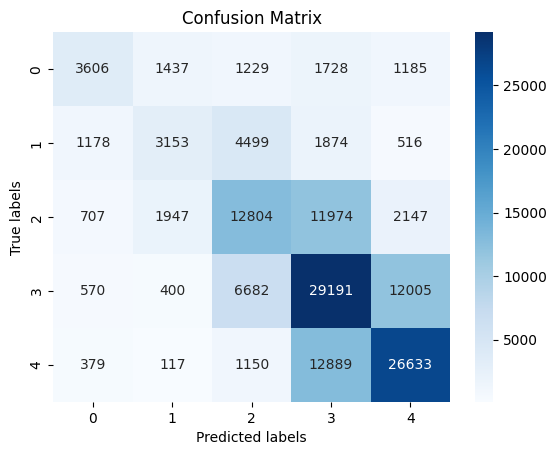

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_value, y_pred)

sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
X_test = v.transform(test['review_text_clean'])

In [ ]:
pred_test = mod.predict(X_test)

In [ ]:
print(pred_test)

[3 5 5 ... 3 4 4]


In [ ]:
pred_test.shape

(200000,)

In [ ]:
test['rating']=pred_test
test['rating']=pred_test
df_output=test[['review_id','rating']]

In [ ]:
df_output.to_csv("/content/drive/MyDrive/Dataset/Rrgression_5.CSV",index=False)

# 3Layer NN Baseline:

My 3-Layer Neural Network Model consists of an input layer, a hidden layer, and an output layer, where each layer contains one or more neurons. These neurons are computational units that perform mathematical operations on the input data. Given the necessity to experiment with different parameters for the task at hand, I find this model to be the best fit for such tasks.

In [ ]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Concatenate, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/Dataset/my_goodreads_train.csv")
test = pd.read_csv("/content/drive/MyDrive/Dataset/my_goodreads_test.csv")

In [ ]:
pip install neattext

In [ ]:
import neattext as nt
import neattext.functions as nfx
#removing custom patterns like $&\+
train['review_text_clean']=train['review_text'].apply(lambda x:nfx.remove_custom_pattern(x,term_pattern=r'$&\+'))

#removing'\n'
train['review_text_clean']=train['review_text_clean'].apply(lambda x:nfx.remove_custom_pattern(x,term_pattern=r'\n'))

#removing special characters
train['review_text_clean']=train['review_text_clean'].apply(nfx.remove_special_characters)

#removing multiple spacing
train['review_text_clean']=train['review_text_clean'].apply(nfx.remove_multiple_spaces)

train['review_text_clean']=train['review_text_clean'].apply(nfx.remove_stopwords)


In [ ]:
max_words = 10000
max_len = 500
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train['review_text_clean']) # lemmatized_text is a list of strings
sequences = tokenizer.texts_to_sequences(train['review_text_clean'])
text_data = pad_sequences(sequences,maxlen=max_len)

In [ ]:
train_f = pd.concat([pd.DataFrame(text_data)], axis=1)

In [ ]:
from sklearn.model_selection import train_test_split
x_train = train_f
y_train = np.array(train[['rating']])

X_train_full, X_test, y_train_full, y_test = train_test_split(x_train, y_train)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=x_train.shape[1:]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(6, activation="softmax")
])

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# One-hot encode the y_train and y_valid variables
y_train = to_categorical(y_train)
y_valid = to_categorical(y_valid)
y_test = to_categorical(y_test)

In [ ]:
batch_size = 23
print("Batch Size: {}".format(batch_size))
history = model.fit(X_train, y_train, epochs=5, batch_size=batch_size, validation_data=(X_valid, y_valid))

Batch Size: 23
Epoch 1/5
17120/17120 [==============================] - 62s 3ms/step - loss: 2.0868 - accuracy: 0.3346 - val_loss: 0.3836 - val_accuracy: 0.3487
Epoch 2/5
17120/17120 [==============================] - 56s 3ms/step - loss: 0.3827 - accuracy: 0.3487 - val_loss: 0.3828 - val_accuracy: 0.3484
Epoch 3/5
17120/17120 [==============================] - 56s 3ms/step - loss: 0.3819 - accuracy: 0.3489 - val_loss: 0.3827 - val_accuracy: 0.3485
Epoch 4/5
17120/17120 [==============================] - 56s 3ms/step - loss: 0.3820 - accuracy: 0.3491 - val_loss: 0.3828 - val_accuracy: 0.3484
Epoch 5/5
17120/17120 [==============================] - 55s 3ms/step - loss: 0.3819 - accuracy: 0.3490 - val_loss: 0.3827 - val_accuracy: 0.3487


(0.0, 1.0)

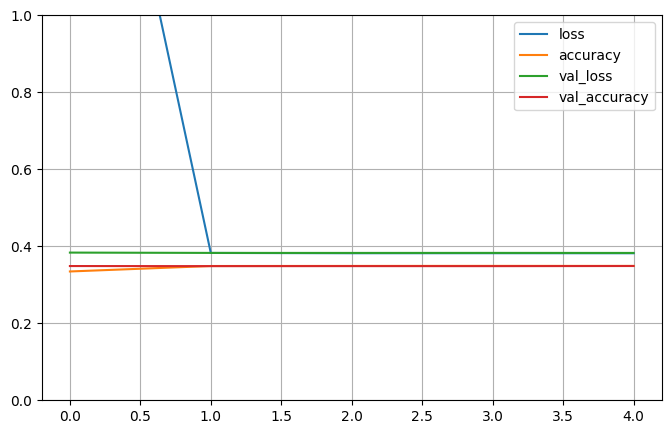

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1] plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
test_acc

5469/5469 [==============================] - 11s 2ms/step - loss: 0.3822 - accuracy: 0.3499


0.34994858503341675

In [ ]:
# Define the number of neurons to experiment with
n_neurons_list = [1, 20, 50,80,100]
# Create lists to store results
val_scores = []
# Define the model architecture with 3 layers
def build_model(n_neurons):
    model1 = keras.models.Sequential([
        keras.layers.Dense(n_neurons, activation="relu", input_shape=X_train.shape[1:]),
        keras.layers.Dense(10, activation="relu"),
        keras.layers.Dense(6)
    ])
    model1.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    batch_size = 23
    print("Batch Size: {}".format(batch_size))
    return model1


# Train the model for each number of neurons and store the validation score
for n_neurons in n_neurons_list:
    model1 = build_model(n_neurons)
    history = model1.fit(X_train, y_train, epochs=5, validation_data=(X_valid, y_valid), verbose=1)
    val_scores.append(history.history['val_loss'][-1])

Batch Size: 23
Epoch 1/5
12305/12305 [==============================] - 44s 4ms/step - loss: 1.8122 - accuracy: 0.2943 - val_loss: 1.7865 - val_accuracy: 0.2935
Epoch 2/5
12305/12305 [==============================] - 42s 3ms/step - loss: 1.7830 - accuracy: 0.2953 - val_loss: 1.7865 - val_accuracy: 0.2935
Epoch 3/5
12305/12305 [==============================] - 42s 3ms/step - loss: 1.7829 - accuracy: 0.2953 - val_loss: 1.7865 - val_accuracy: 0.2935
Epoch 4/5
12305/12305 [==============================] - 42s 3ms/step - loss: 1.7830 - accuracy: 0.2953 - val_loss: 1.7868 - val_accuracy: 0.2935
Epoch 5/5
12305/12305 [==============================] - 43s 3ms/step - loss: 1.7966 - accuracy: 0.2952 - val_loss: 1.7871 - val_accuracy: 0.2935
Batch Size: 23
Epoch 1/5
12305/12305 [==============================] - 44s 3ms/step - loss: 3.7128 - accuracy: 0.2589 - val_loss: 2.5659 - val_accuracy: 0.2117
Epoch 2/5
12305/12305 [==============================] - 43s 3ms/step - loss: 2.5469 - accurac

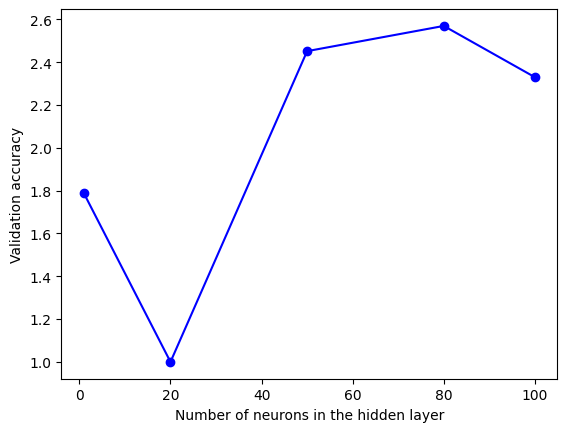

In [ ]:
# Plot the validation score for each number of neurons
plt.plot(n_neurons_list, val_scores, "bo-")
plt.xlabel("Number of neurons in the hidden layer")
plt.ylabel("Validation accuracy")
plt.show()

In [ ]:
# Best result for neurons
x_train = train_f
y_train = np.array(train[['rating']])

X_train_full, X_test, y_train_full, y_test = train_test_split(x_train, y_train)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full)

y_train = to_categorical(y_train)
y_valid = to_categorical(y_valid)
y_test = to_categorical(y_test)

model2= keras.models.Sequential([
    keras.layers.Flatten(input_shape=x_train.shape[1:]),
    keras.layers.Dense(80, activation="relu"),
    keras.layers.Dense(6, activation="softmax")
])

model2.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
12305/12305 [==============================] - 42s 3ms/step - loss: 0.3824 - accuracy: 0.3493 - val_loss: 0.3819 - val_accuracy: 0.3503
Epoch 2/10
12305/12305 [==============================] - 40s 3ms/step - loss: 0.3821 - accuracy: 0.3493 - val_loss: 0.3817 - val_accuracy: 0.3501
Epoch 3/10
12305/12305 [==============================] - 40s 3ms/step - loss: 0.3820 - accuracy: 0.3494 - val_loss: 0.3816 - val_accuracy: 0.3499
Epoch 4/10
12305/12305 [==============================] - 40s 3ms/step - loss: 0.3820 - accuracy: 0.3493 - val_loss: 0.3816 - val_accuracy: 0.3498
Epoch 5/10
12305/12305 [==============================] - 39s 3ms/step - loss: 0.3820 - accuracy: 0.3494 - val_loss: 0.3816 - val_accuracy: 0.3501
Epoch 6/10
12305/12305 [==============================] - 39s 3ms/step - loss: 0.3821 - accuracy: 0.3494 - val_loss: 0.3815 - val_accuracy: 0.3505
Epoch 7/10
12305/12305 [==============================] - 39s 3ms/step - loss: 0.3820 - accuracy: 0.3493 - val_loss: 0

In [ ]:
test['review_text_clean']=test['review_text'].apply(lambda x:nfx.remove_custom_pattern(x,term_pattern=r'$&\+'))
test['review_text_clean']=test['review_text_clean'].apply(lambda x:nfx.remove_custom_pattern(x,term_pattern=r'\n'))
test['review_text_clean']=test['review_text_clean'].apply(nfx.remove_special_characters)
test['review_text_clean']=test['review_text_clean'].apply(nfx.remove_multiple_spaces)
test['review_text_clean']=test['review_text_clean'].apply(nfx.remove_stopwords)


In [ ]:
#deal test (y_predit)
max_words = 10000
max_len = 500
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(test['review_text_clean']) # lemmatized_text is a list of strings
sequences = tokenizer.texts_to_sequences(test['review_text_clean'])
text_data_test = pad_sequences(sequences,maxlen=max_len)

Y_testdata= pd.concat([pd.DataFrame(text_data_test)], axis=1)

Y_pred=model2.predict(Y_testdata)
Y_predit_convert=np.argmax(Y_pred,axis=-1)
Y_predit_convert

6250/6250 [==============================] - 8s 1ms/step


array([5, 5, 0, ..., 2, 5, 5])

In [ ]:
std_dev=np.std(Y_predit_convert)
std_dev

1.837725871586946

In [ ]:
test['rating']= Y_predit_convert

In [ ]:
df_output=test[['review_id','rating']]
df_output.to_csv("/content/drive/MyDrive/Dataset/3NN_5.CSV",index=False)

# Deep NN

For my deep neural networks model, I decided to create a 7-layer DNN model that includes 3 base layers of neurons. I explored the optimum number of layers needed and concluded that adding more layers would incrementally improve performance. Based on my best result, which was achieved with 15 layers and 55 neurons (the best configuration from the initial 3 layers), I tested various activation functions like relu, sigmoid, tanh, and elu. I did this to gain a better understanding of the model and to enhance its performance.

In [ ]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
import tensorflow as tf
import os
from tensorflow.keras.layers import Input, Dense, Embedding, Concatenate, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/Dataset/my_goodreads_train.csv")
test = pd.read_csv("/content/drive/MyDrive/Dataset/my_goodreads_test.csv")

In [ ]:
import neattext as nt
import neattext.functions as nfx
#removing custom patterns like $&\+
train['review_text_clean']=train['review_text'].apply(lambda x:nfx.remove_custom_pattern(x,term_pattern=r'$&\+'))

#removing'\n'
train['review_text_clean']=train['review_text_clean'].apply(lambda x:nfx.remove_custom_pattern(x,term_pattern=r'\n'))

#removing special characters
train['review_text_clean']=train['review_text_clean'].apply(nfx.remove_special_characters)

#removing multiple spacing
train['review_text_clean']=train['review_text_clean'].apply(nfx.remove_multiple_spaces)

train['review_text_clean']=train['review_text_clean'].apply(nfx.remove_stopwords)


In [ ]:
max_words = 10000
max_len = 110
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train['review_text_clean']) # lemmatized_text is a list of strings
sequences = tokenizer.texts_to_sequences(train['review_text_clean'])
text_data = pad_sequences(sequences,maxlen=max_len)

In [ ]:
train_f = pd.concat([pd.DataFrame(text_data)], axis=1)

In [ ]:
from sklearn.model_selection import train_test_split
x_train = train_f
y_train = np.array(train[['rating']])

X_train_full, X_test, y_train_full, y_test = train_test_split(x_train, y_train)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=x_train.shape[1:]),
    keras.layers.Dense(80, activation="relu"),
    keras.layers.Dense(80, activation="relu"),
    keras.layers.Dense(80, activation="relu"),
    keras.layers.Dense(80, activation="relu"),
    keras.layers.Dense(80, activation="relu"),
    keras.layers.Dense(80, activation="relu"),
    keras.layers.Dense(6, activation="softmax")
])

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# One-hot encode the y_train and y_valid variables
y_train = to_categorical(y_train)
y_valid = to_categorical(y_valid)
y_test = to_categorical(y_test)

In [ ]:
batch_size = 23
print("Batch Size: {}".format(batch_size))
history = model.fit(X_train, y_train, epochs=5, batch_size=batch_size, validation_data=(X_valid, y_valid))

Batch Size: 23
Epoch 1/5
17120/17120 [==============================] - 76s 4ms/step - loss: 0.4432 - accuracy: 0.3421 - val_loss: 0.3814 - val_accuracy: 0.3443
Epoch 2/5
17120/17120 [==============================] - 71s 4ms/step - loss: 0.3814 - accuracy: 0.3490 - val_loss: 0.3809 - val_accuracy: 0.3471
Epoch 3/5
17120/17120 [==============================] - 71s 4ms/step - loss: 0.3812 - accuracy: 0.3497 - val_loss: 0.3817 - val_accuracy: 0.3469
Epoch 4/5
17120/17120 [==============================] - 71s 4ms/step - loss: 0.3812 - accuracy: 0.3495 - val_loss: 0.3815 - val_accuracy: 0.3468
Epoch 5/5
17120/17120 [==============================] - 71s 4ms/step - loss: 0.3814 - accuracy: 0.3499 - val_loss: 0.3819 - val_accuracy: 0.3470


(0.0, 1.0)

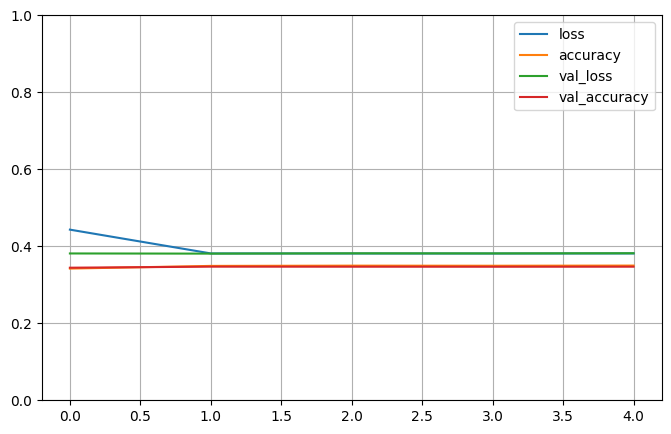

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1] plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
test_acc

5469/5469 [==============================] - 11s 2ms/step - loss: 0.3819 - accuracy: 0.3491


0.34914857149124146

In [ ]:
# Define the number of layers
n_layers_list = [1, 3, 5, 10, 15]

val_scores = []

def build_model(n_layers, n_neurons):
    model_L = keras.models.Sequential()
    model_L.add(keras.layers.Dense(80, activation="relu", input_shape=X_train.shape[1:]))
    for i in range(n_layers):
        model_L.add(keras.layers.Dense(80, activation="relu"))
    model_L.add(keras.layers.Dense(6, activation="softmax"))
    model_L.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model_L


for n in n_layers_list:
    model_L = build_model(n, n_neurons=80)
    history = model.fit(X_train, y_train, epochs=5, batch_size=23, validation_data=(X_valid, y_valid), verbose=1)
    val_scores.append(history.history['val_loss'][-1])

Epoch 1/5
17120/17120 [==============================] - 71s 4ms/step - loss: 0.3816 - accuracy: 0.3498 - val_loss: 0.3821 - val_accuracy: 0.3470
Epoch 2/5
17120/17120 [==============================] - 70s 4ms/step - loss: 0.3816 - accuracy: 0.3503 - val_loss: 0.4077 - val_accuracy: 0.3476
Epoch 3/5
17120/17120 [==============================] - 70s 4ms/step - loss: 0.3816 - accuracy: 0.3497 - val_loss: 0.3817 - val_accuracy: 0.3472
Epoch 4/5
17120/17120 [==============================] - 70s 4ms/step - loss: 0.3816 - accuracy: 0.3495 - val_loss: 0.3819 - val_accuracy: 0.3468
Epoch 5/5
17120/17120 [==============================] - 70s 4ms/step - loss: 0.3814 - accuracy: 0.3498 - val_loss: 0.3817 - val_accuracy: 0.3473
Epoch 1/5
17120/17120 [==============================] - 70s 4ms/step - loss: 0.3830 - accuracy: 0.3498 - val_loss: 0.3816 - val_accuracy: 0.3469
Epoch 2/5
17120/17120 [==============================] - 70s 4ms/step - loss: 0.3828 - accuracy: 0.3505 - val_loss: 0.3815 -

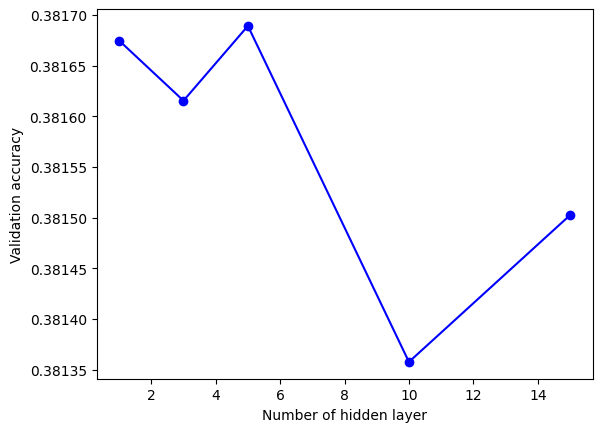

In [ ]:
plt.plot(n_layers_list, val_scores, "bo-")
plt.xlabel("Number of hidden layer")
plt.ylabel("Validation accuracy")

plt.show()

In [ ]:
# Define the activation functions to test
import matplotlib.pyplot as plt

# Define the activation functions to test
activation_functions = ['relu', 'sigmoid', 'tanh', 'elu']

val_scores = {}

for activation in activation_functions:
    model_A = keras.models.Sequential([
        keras.layers.Dense(80, activation=activation, input_shape=X_train.shape[1:])
    ])

    # Add 29 more layers with the same activation function
    for i in range(4):
        model_A.add(keras.layers.Dense(80, activation=activation))

    model_A.add(keras.layers.Dense(6, activation='softmax'))

    model_A.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    history = model_A.fit(X_train, y_train, epochs=5, batch_size=23, validation_data=(X_valid, y_valid), verbose=1)

    val_scores[activation] = history.history['val_loss'][-1]

Epoch 1/5
17120/17120 [==============================] - 75s 4ms/step - loss: 0.5051 - accuracy: 0.3390 - val_loss: 0.3819 - val_accuracy: 0.3475
Epoch 2/5
17120/17120 [==============================] - 67s 4ms/step - loss: 0.3817 - accuracy: 0.3499 - val_loss: 0.3820 - val_accuracy: 0.3479
Epoch 3/5
17120/17120 [==============================] - 68s 4ms/step - loss: 0.3818 - accuracy: 0.3503 - val_loss: 0.3817 - val_accuracy: 0.3477
Epoch 4/5
17120/17120 [==============================] - 67s 4ms/step - loss: 0.3815 - accuracy: 0.3506 - val_loss: 0.3815 - val_accuracy: 0.3483
Epoch 5/5
17120/17120 [==============================] - 67s 4ms/step - loss: 0.3818 - accuracy: 0.3508 - val_loss: 0.3817 - val_accuracy: 0.3474
Epoch 1/5
17120/17120 [==============================] - 69s 4ms/step - loss: 0.3818 - accuracy: 0.3463 - val_loss: 0.3816 - val_accuracy: 0.3462
Epoch 2/5
17120/17120 [==============================] - 67s 4ms/step - loss: 0.3811 - accuracy: 0.3484 - val_loss: 0.3816 -

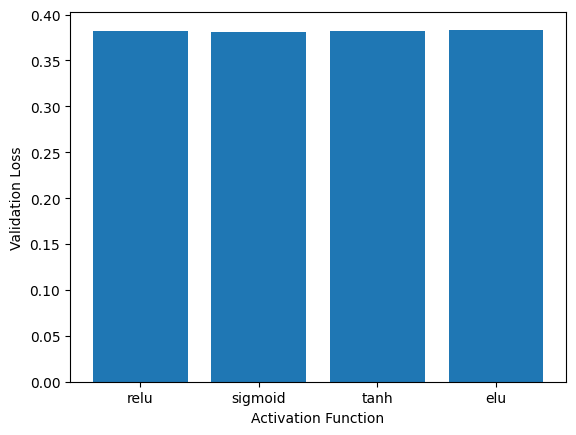

In [ ]:
# Plot the validation scores for each activation function
plt.bar(range(len(val_scores)), list(val_scores.values()), align='center')
plt.xticks(range(len(val_scores)), list(val_scores.keys()))
plt.xlabel('Activation Function')
plt.ylabel('Validation Loss')
plt.show()

In [ ]:
x_train = train_f
y_train = np.array(train[['rating']])

X_train_full, X_test, y_train_full, y_test = train_test_split(x_train, y_train)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full)

train_f = pd.concat([ pd.DataFrame(text_data)], axis=1)

model_R = keras.models.Sequential([
    keras.layers.Flatten(input_shape=x_train.shape[1:]),
    keras.layers.Dense(80, activation="relu"),
    keras.layers.Dense(80, activation="relu"),
    keras.layers.Dense(80, activation="relu"),
    keras.layers.Dense(80, activation="relu"),
    keras.layers.Dense(6, activation="softmax")
])
model_R.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

y_train = to_categorical(y_train)
y_valid = to_categorical(y_valid)
y_test = to_categorical(y_test)

history = model_R.fit(X_train, y_train, epochs=5, validation_data=(X_valid, y_valid))

Epoch 1/5
12305/12305 [==============================] - 49s 4ms/step - loss: 0.7508 - accuracy: 0.3282 - val_loss: 0.3810 - val_accuracy: 0.3496
Epoch 2/5
12305/12305 [==============================] - 46s 4ms/step - loss: 0.3820 - accuracy: 0.3477 - val_loss: 0.3811 - val_accuracy: 0.3512
Epoch 3/5
12305/12305 [==============================] - 46s 4ms/step - loss: 0.3818 - accuracy: 0.3483 - val_loss: 0.3811 - val_accuracy: 0.3512
Epoch 4/5
12305/12305 [==============================] - 46s 4ms/step - loss: 0.3818 - accuracy: 0.3486 - val_loss: 0.3808 - val_accuracy: 0.3501
Epoch 5/5
12305/12305 [==============================] - 46s 4ms/step - loss: 0.3815 - accuracy: 0.3487 - val_loss: 0.3808 - val_accuracy: 0.3504


In [ ]:
test['review_text_clean']=test['review_text'].apply(lambda x:nfx.remove_custom_pattern(x,term_pattern=r'$&\+'))
test['review_text_clean']=test['review_text_clean'].apply(lambda x:nfx.remove_custom_pattern(x,term_pattern=r'\n'))
test['review_text_clean']=test['review_text_clean'].apply(nfx.remove_special_characters)
test['review_text_clean']=test['review_text_clean'].apply(nfx.remove_multiple_spaces)
test['review_text_clean']=test['review_text_clean'].apply(nfx.remove_stopwords)

In [ ]:
#deal test (y_predit)
max_words = 10000
max_len = 110
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(test['review_text_clean']) # lemmatized_text is a list of strings
sequences = tokenizer.texts_to_sequences(test['review_text_clean'])
text_data_test = pad_sequences(sequences,maxlen=max_len)

Y_testdata= pd.concat([pd.DataFrame(text_data_test)], axis=1)

Y_pred=model_R.predict(Y_testdata)
Y_predit_convert=np.argmax(Y_pred,axis=-1)
Y_predit_convert

6250/6250 [==============================] - 9s 1ms/step


array([4, 4, 4, ..., 4, 4, 4])

In [ ]:
std_dev=np.std(Y_predit_convert)
std_dev

0.1628110484580208

# Complex Neural Network Models:

I have prominently used 3 Complex Neural Network Models namely, Recurrent Neural Network Model (RNN), Long Short-Term Models (LSTMs) and Bidirectional Encoder Representations from Transformer (BERT).

## RNN

Recurrent Neural Network Model (RNN): it is a type of neural network designed to handle sequential data as against the neural networks which process data in a fixed sequence of layers. I found it difficult to find the parameters to tune the model however, I was successful in generating a decent output for the same.

In [ ]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/Dataset/training_set_preprocessed_str.csv")
test = pd.read_csv("/content/drive/MyDrive/Dataset/testing_set_preprocessed_str.csv")

In [ ]:
train.head()

,review_text_clean,rating,book_id,n_votes,n_comments,lemmatized_text
0,thought good historical fantasy set new york c...,5,182091851,5,6,"['thought', 'good', 'historical', 'fantasy', '..."
1,35 stars rounded cant help dont connect theo p...,3,195643271,0,0,"['star', 'round', 'cant', 'help', 'dont', 'con..."
2,read wasp factory scottish literature class ye...,2,1876765,0,0,"['read', 'wasp', 'factory', 'scottish', 'liter..."
3,unexpected read venture world contemporary rom...,5,100833271,0,0,"['unexpected', 'read', 'venture', 'world', 'co..."
4,dnf 49 dont know expecting bookmaybe dealing s...,1,133218621,0,0,"['dnf', 'dont', 'know', 'expect', 'bookmaybe',..."


In [ ]:
train['rating'].unique()

array([5, 3, 2, 1, 4])

In [ ]:
from tensorflow.keras.layers import Input, Dense, Embedding, Concatenate, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.layers import SimpleRNN

In [ ]:
max_words = 10000
max_len = 500
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train['lemmatized_text']) # lemmatized_text is a list of strings
sequences = tokenizer.texts_to_sequences(train['lemmatized_text'])
text_data = pad_sequences(sequences,maxlen=max_len)

In [ ]:
train_f = pd.concat([ pd.DataFrame(text_data)], axis=1)

In [ ]:
x_train = train_f
y_train = np.array(train[['rating']])

In [ ]:
X_train_full, X_test, y_train_full, y_test = train_test_split(x_train, y_train)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full)

In [ ]:
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

y_train = tf.keras.utils.to_categorical(y_train,num_classes=6)
y_valid = tf.keras.utils.to_categorical(y_valid,num_classes=6)
y_test = tf.keras.utils.to_categorical(y_test,num_classes=6)


X_train=np.expand_dims(X_train,-1)
X_test=np.expand_dims(X_test,-1)
X_valid=np.expand_dims(X_valid,-1)

model = keras.models.Sequential([
keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
keras.layers.SimpleRNN(20, return_sequences=True),
keras.layers.SimpleRNN(6)
])

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, None, 20)          440       
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, None, 20)          820       
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 6)                 162       
                                                                 
Total params: 1,422
Trainable params: 1,422
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#batch_size = 100
#print("Batch Size: {}".format(batch_size))
#history = model.fit(X_train, y_train, epochs=5, batch_size=batch_size, validation_data=(X_valid, y_valid))

In [ ]:
#pd.DataFrame(history.history).plot(figsize=(8, 5))
#plt.grid(True)
#plt.gca().set_ylim(0, 1) # set the vertical range to [0-1] plt.show()

In [ ]:
from tensorflow.keras.utils import to_categorical
test_loss, test_acc = model.evaluate(X_test, y_test)
test_acc

In [ ]:
model.save('/content/drive/MyDrive/Dataset/RNN_model_5.h5')

In [ ]:
import keras
from keras.models import load_model
model = load_model('/content/drive/MyDrive/Dataset/RNN_model_5.h5')

In [ ]:
#deal test (y_predit)
max_words = 10000
max_len = 500
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(test['lemmatized_text']) # lemmatized_text is a list of strings
sequences = tokenizer.texts_to_sequences(test['lemmatized_text'])
text_data_test = pad_sequences(sequences,maxlen=max_len)

Y_testdata= pd.concat([pd.DataFrame(text_data_test)], axis=1)

Y_pred=model.predict(Y_testdata)
Y_predit_convert=np.argmax(Y_pred,axis=-1)
Y_predit_convert

6250/6250 [==============================] - 697s 111ms/step


array([2, 1, 2, ..., 1, 2, 2])

In [ ]:
std_dev=np.std(Y_predit_convert)
std_dev

0.2996395851268654

In [ ]:
test['rating']= Y_predit_convert
df_output=test[['review_id','rating']]
df_output.to_csv("/content/drive/MyDrive/Dataset/RNN.csv",index=False)

#GRU

I've been working with Gated Recurrent Units (GRUs), which are essentially a variant of Recurrent Neural Networks designed to handle sequential data, like text and speech. They're similar to LSTMs because they also use gating mechanisms to control the flow of information through the network. However, in my experience, I've noticed that the performance of the model depends on several factors, such as the quantity/size of the input data and the choice of parameters/hyperparameters, among others.

In [ ]:

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, GRU, Dense, Dropout
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/my_goodreads_train.csv")
test = pd.read_csv("/content/drive/MyDrive/my_goodreads_test.csv")

In [ ]:
train.head()

,user_id,book_id,review_id,rating,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments
0,1da3dcc13cf360b9ecb06251e86237535,182091851,1c949b5dedf860514ec8b97ad158c9f4f,5,I thought this was a very good historical fant...,Fri Feb 01 16:44:16 -0800 2013,Tue Oct 25 18:49:25 -0700 2016,Sat May 04 00:00:00 -0700 2013,Thu Apr 25 00:00:00 -0700 2013,5,6
1,1ae436441b6153473ef907aed1006a159,1451461,112ee86a20d7e4308c0a054f8b03128cd,5,I've had this book recommended to me more than...,Sun Nov 08 12:10:16 -0800 2015,Sun Nov 08 12:24:59 -0800 2015,Tue May 05 00:00:00 -0700 2015,Sun May 03 00:00:00 -0700 2015,0,0
2,1aa5e9d859b0c0737f4b99a07edf19c88,13483572,1253729b67f301b75a0f26e85f6d6fb31,5,Seriously! You go and throw that twist into th...,Wed Oct 10 02:07:19 -0700 2012,Sat Apr 27 00:40:19 -0700 2013,Sat Apr 27 00:40:19 -0700 2013,Thu Apr 25 00:00:00 -0700 2013,0,0
3,1940c22aba67c3d49ccd37891c52c9f51,131585171,1ae0005e94dce0dc5c18d6ae2b4a329ab,4,Gosh!!! I'm still not recovering from the effi...,Thu Dec 05 00:45:29 -0800 2013,Thu Dec 05 00:50:17 -0800 2013,Thu Dec 05 00:50:17 -0800 2013,Wed Dec 04 00:00:00 -0800 2013,5,0
4,15e03534fccd0e7e1849d712ab9e44342,195643271,1d8357d2abdcc656635c5459c1feec761,3,"3.5 stars rounded down. I can't help it, I jus...",Wed Mar 15 18:08:14 -0700 2017,Wed Jul 05 12:55:32 -0700 2017,Wed Apr 12 12:17:07 -0700 2017,Tue Apr 11 00:00:00 -0700 2017,0,0


In [ ]:
!pip install neattext

In [ ]:
import neattext as nt
import neattext.functions as nfx

In [ ]:
#removing custom patterns like $&\+
train['review_text_clean']=train['review_text'].apply(lambda x:nfx.remove_custom_pattern(x,term_pattern=r'$&\+'))

#removing'\n'
train['review_text_clean']=train['review_text_clean'].apply(lambda x:nfx.remove_custom_pattern(x,term_pattern=r'\n'))

#removing special characters
train['review_text_clean']=train['review_text_clean'].apply(nfx.remove_special_characters)

#removing multiple spacing
train['review_text_clean']=train['review_text_clean'].apply(nfx.remove_multiple_spaces)

train['review_text_clean']=train['review_text_clean'].apply(nfx.remove_stopwords)


In [ ]:
test['review_text_clean']=test['review_text'].apply(lambda x:nfx.remove_custom_pattern(x,term_pattern=r'$&\+'))
test['review_text_clean']=test['review_text_clean'].apply(lambda x:nfx.remove_custom_pattern(x,term_pattern=r'\n'))
test['review_text_clean']=test['review_text_clean'].apply(nfx.remove_special_characters)
test['review_text_clean']=test['review_text_clean'].apply(nfx.remove_multiple_spaces)
test['review_text_clean']=test['review_text_clean'].apply(nfx.remove_stopwords)


In [ ]:
# Tokenize the text
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(train["review_text_clean"])

In [ ]:
# Convert text to sequences
X_train = tokenizer.texts_to_sequences(train["review_text_clean"])
X_test = tokenizer.texts_to_sequences(test["review_text_clean"])

In [ ]:
# Pad sequences to the same length
X_train = pad_sequences(X_train, padding="post", maxlen=200)
X_test = pad_sequences(X_test, padding="post", maxlen=200)

In [ ]:
# Define the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential([
    Input(shape=(200,)),
    Embedding(5000, 64),
    GRU(128, return_sequences=True),
    Dropout(0.2),
    GRU(64, return_sequences=True),
    Dropout(0.2),
    GRU(32),
    Dropout(0.2),
    Dense(6, activation="softmax")
])


In [ ]:
# Convert ratings to integers
train["rating"] = train["rating"].astype(int)

In [ ]:
# Convert ratings to integers
y_train = train["rating"].astype(int)

In [ ]:
# Compile the model
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])


In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, verbose=1)

Epoch 1/10
21875/21875 [==============================] - 541s 24ms/step - loss: 1.0873 - accuracy: 0.5228
Epoch 2/10
21875/21875 [==============================] - 407s 19ms/step - loss: 0.9784 - accuracy: 0.5750
Epoch 3/10
21875/21875 [==============================] - 398s 18ms/step - loss: 0.9486 - accuracy: 0.5884
Epoch 4/10
21875/21875 [==============================] - 396s 18ms/step - loss: 0.9256 - accuracy: 0.5994
Epoch 5/10
21875/21875 [==============================] - 396s 18ms/step - loss: 0.9050 - accuracy: 0.6087
Epoch 6/10
21875/21875 [==============================] - 395s 18ms/step - loss: 0.8861 - accuracy: 0.6185
Epoch 7/10
21875/21875 [==============================] - 396s 18ms/step - loss: 0.8694 - accuracy: 0.6264
Epoch 8/10
21875/21875 [==============================] - 395s 18ms/step - loss: 0.8546 - accuracy: 0.6335
Epoch 9/10
21875/21875 [==============================] - 394s 18ms/step - loss: 0.8427 - accuracy: 0.6395
Epoch 10/10
21875/21875 [============

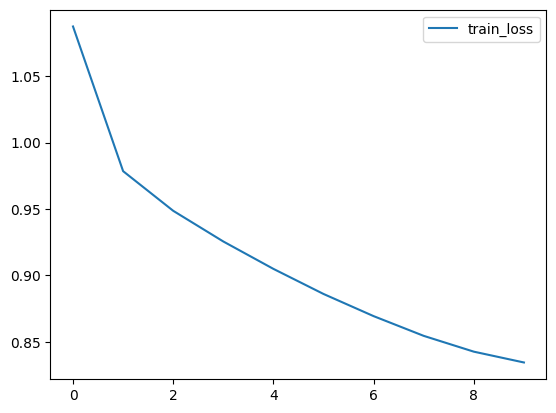

In [ ]:
# Plot the training loss
plt.plot(history.history["loss"], label="train_loss")
plt.legend()
plt.show()

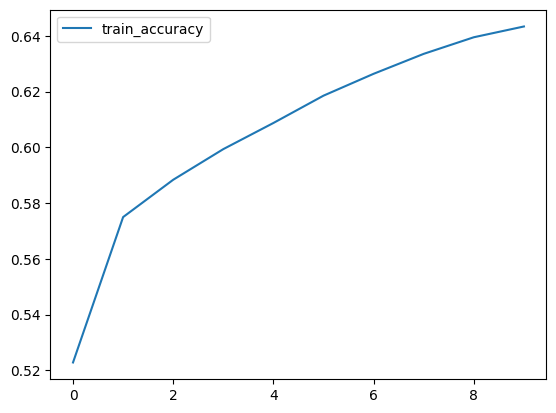

In [ ]:
# Plot the training accuracy
plt.plot(history.history["accuracy"], label="train_accuracy")
plt.legend()
plt.show()

In [ ]:
# Evaluate the model on the training set
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
print("Training accuracy:", train_acc)

Training accuracy: 0.6675828695297241


In [ ]:
# Make predictions on the test set
predictions = model.predict(X_test)

6250/6250 [==============================] - 51s 8ms/step


In [ ]:
y_test = test["rating"].astype(int)
mse = np.mean((predictions.argmax(axis=1)- y_test)**2)
sd = np.std((predictions.argmax(axis=1)- y_test)**2)

print("MSE", mse)
print("SD", sd)


In [ ]:
predicted_ratings = np.argmax(predictions, axis=1)

In [ ]:
test['predicted_rating'] = predicted_ratings

In [ ]:
print(predicted_ratings[:10])

[3 5 4 4 2 4 4 4 3 3]


In [ ]:
df_output=test[['review_id','predicted_rating']]
df_output.to_csv("/content/drive/MyDrive/GRU.csv",index=False)

# BERT

I used the Bidirectional Encoder Representations from Transformer (BERT), a pre-trained deep learning model, because I found it incredibly effective for language processing tasks. I chose it as I believe it's a powerful tool for handling large amounts of data. However, I also realized that it has a significant drawback: it requires substantial computational resources to train and enhance the model's performance.

In [ ]:
!pip install transformers

In [ ]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import tensorflow as tf
from transformers import BertTokenizer

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/my_goodreads_train.csv")
test = pd.read_csv("/content/drive/MyDrive/my_goodreads_test.csv")

In [ ]:
!pip install neattext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import neattext as nt
import neattext.functions as nfx

In [ ]:
#removing custom patterns like $&\+
train['review_text_clean']=train['review_text'].apply(lambda x:nfx.remove_custom_pattern(x,term_pattern=r'$&\+'))

#removing new lines
train['review_text_clean']=train['review_text_clean'].apply(lambda x:nfx.remove_custom_pattern(x,term_pattern=r'\n'))

#ewmoving special characters
train['review_text_clean']=train['review_text_clean'].apply(nfx.remove_special_characters)

#removing multiple spacing
train['review_text_clean']=train['review_text_clean'].apply(nfx.remove_multiple_spaces)

#removing stopwords
train['review_text_clean']=train['review_text_clean'].apply(nfx.remove_stopwords)

In [ ]:
#removing custom patterns like $&\+
test['review_text_clean']=test['review_text'].apply(lambda x:nfx.remove_custom_pattern(x,term_pattern=r'$&\+'))

#removing new lines
test['review_text_clean']=test['review_text_clean'].apply(lambda x:nfx.remove_custom_pattern(x,term_pattern=r'\n'))

#ewmoving special characters
test['review_text_clean']=test['review_text_clean'].apply(nfx.remove_special_characters)

#removing multiple spacing
test['review_text_clean']=test['review_text_clean'].apply(nfx.remove_multiple_spaces)

#removing stopwords
test['review_text_clean']=test['review_text_clean'].apply(nfx.remove_stopwords)

In [ ]:
# Divide dataset into train and test sets
train_size = int(len(train) * 0.8) # 80% for training, 20% for testing
train_t = train[:train_size]
test_t = train[train_size:]

In [ ]:
train_t

,user_id,book_id,review_id,rating,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments,review_text_clean
0,1da3dcc13cf360b9ecb06251e86237535,182091851,1c949b5dedf860514ec8b97ad158c9f4f,5,I thought this was a very good historical fant...,Fri Feb 01 16:44:16 -0800 2013,Tue Oct 25 18:49:25 -0700 2016,Sat May 04 00:00:00 -0700 2013,Thu Apr 25 00:00:00 -0700 2013,5,6,thought good historical fantasy set New York C...
1,1ae436441b6153473ef907aed1006a159,1451461,112ee86a20d7e4308c0a054f8b03128cd,5,I've had this book recommended to me more than...,Sun Nov 08 12:10:16 -0800 2015,Sun Nov 08 12:24:59 -0800 2015,Tue May 05 00:00:00 -0700 2015,Sun May 03 00:00:00 -0700 2015,0,0,Ive book recommended decided shot Turns pretty...
2,1aa5e9d859b0c0737f4b99a07edf19c88,13483572,1253729b67f301b75a0f26e85f6d6fb31,5,Seriously! You go and throw that twist into th...,Wed Oct 10 02:07:19 -0700 2012,Sat Apr 27 00:40:19 -0700 2013,Sat Apr 27 00:40:19 -0700 2013,Thu Apr 25 00:00:00 -0700 2013,0,0,Seriously throw twist story kills love series ...
3,1940c22aba67c3d49ccd37891c52c9f51,131585171,1ae0005e94dce0dc5c18d6ae2b4a329ab,4,Gosh!!! I'm still not recovering from the effi...,Thu Dec 05 00:45:29 -0800 2013,Thu Dec 05 00:50:17 -0800 2013,Thu Dec 05 00:50:17 -0800 2013,Wed Dec 04 00:00:00 -0800 2013,5,0,Gosh Im recovering effing CLIFFHANGER book WAY...
4,15e03534fccd0e7e1849d712ab9e44342,195643271,1d8357d2abdcc656635c5459c1feec761,3,"3.5 stars rounded down. I can't help it, I jus...",Wed Mar 15 18:08:14 -0700 2017,Wed Jul 05 12:55:32 -0700 2017,Wed Apr 12 12:17:07 -0700 2017,Tue Apr 11 00:00:00 -0700 2017,0,0,35 stars rounded cant help dont connect Theo P...
...,...,...,...,...,...,...,...,...,...,...,...,...
559995,1bade0c12e5863b976c6fe42140f58d15,18097469,177e626270bd35177c6a7019277c9953d,3,"Fun, frilly, light read for a lazy summer day....",Wed Jun 15 08:29:01 -0700 2011,Tue Dec 04 20:36:52 -0800 2012,Sat Jul 23 00:00:00 -0700 2011,NaN,0,0,Fun frilly light read lazy summer day Finished...
559996,1e924d41fd40849709b715942ada74a35,176297431,15ab5ce698b6f55e0d20f984db059456c,2,Kind of a let down for an ending. I am sick of...,Thu Sep 05 17:55:25 -0700 2013,Sat Aug 16 10:55:52 -0700 2014,Sat Aug 16 10:55:52 -0700 2014,Sat Aug 09 00:00:00 -0700 2014,0,0,Kind let ending sick love sight wrap convenien...
559997,10b12a4cf5bc6e5b5df773dcba11eb7a2,12234287,19a4794f6f29cb4f7fd5e019ddbd381d6,4,An important story. I only vaguely knew about ...,Mon Sep 23 14:34:24 -0700 2013,Sat Oct 05 11:52:41 -0700 2013,Sat Oct 05 11:52:41 -0700 2013,NaN,0,0,important story vaguely knew millions people S...
559998,1e9af13168c3293675a2a167204c88fc6,138953711,158870fcd43527f84ba91f5dce4b0ab72,2,"Nope, it's bad this time, disorganized, some e...",Wed May 03 08:18:09 -0700 2017,Fri May 05 02:54:03 -0700 2017,Fri May 05 02:54:03 -0700 2017,Wed May 03 08:18:09 -0700 2017,0,0,Nope bad time disorganized events English magi...


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [ ]:
# Tokenize train and test data separately
train_tokens = tokenizer.batch_encode_plus(
    train_t['review_text_clean'].tolist(),
    max_length=256,
    truncation=True,
    padding='max_length',
    add_special_tokens=True,
    return_tensors='tf'
)
test_tokens = tokenizer.batch_encode_plus(
    test_t['review_text_clean'].tolist(),
    max_length=256,
    truncation=True,
    padding='max_length',
    add_special_tokens=True,
    return_tensors='tf'
)

In [ ]:
# Create input and attention mask arrays for train and test data
X_train_input_ids = np.array(train_tokens['input_ids'])
X_train_attn_masks = np.array(train_tokens['attention_mask'])
X_test_input_ids = np.array(test_tokens['input_ids'])
X_test_attn_masks = np.array(test_tokens['attention_mask'])

In [ ]:
y_train = tf.keras.utils.to_categorical(train_t['rating'], num_classes=6) # one-hot encoded target tensor
y_test = tf.keras.utils.to_categorical(test_t['rating'], num_classes=6)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_input_ids, X_train_attn_masks, y_train))

test_dataset = tf.data.Dataset.from_tensor_slices((X_test_input_ids, X_test_attn_masks, y_test))

In [ ]:
def SentimentDatasetMapFunction(input_ids, attn_masks, labels):
    return {
        'input_ids': input_ids,
        'attention_mask': attn_masks
    }, labels

In [ ]:
train_dataset = train_dataset.map(SentimentDatasetMapFunction)

test_dataset = test_dataset.map(SentimentDatasetMapFunction)

train_dataset = train_dataset.shuffle(10000).batch(16, drop_remainder=True)

test_dataset = test_dataset.batch(16)

In [ ]:
from transformers import TFBertModel
model = TFBertModel.from_pretrained('bert-base-cased')

input_ids = tf.keras.layers.Input(shape=(256,), name='input_ids', dtype='int32')
attn_masks = tf.keras.layers.Input(shape=(256,), name='attention_mask', dtype='int32')

bert_embds = model.bert(input_ids, attention_mask=attn_masks)[1]
intermediate_layer = tf.keras.layers.Dense(512, activation='relu', name='intermediate_layer')(bert_embds)
output_layer = tf.keras.layers.Dense(6, activation='softmax', name='output_layer')(intermediate_layer)

sentiment_model = tf.keras.Model(inputs=[input_ids, attn_masks], outputs=output_layer)
sentiment_model.summary()

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 256,                                           

In [ ]:
optim = tf.keras.optimizers.Adam(learning_rate=1e-5)
loss_func = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')
sentiment_model.compile(optimizer=optim, loss=loss_func, metrics=[acc])

In [ ]:
# '''hist = sentiment_model.fit(
#     train_dataset,
#     validation_data=test_dataset,
#     epochs=2
# )'''

'hist = sentiment_model.fit(\n    train_dataset,\n    validation_data=test_dataset,\n    epochs=2\n)'

In [ ]:
# '''loss: 0.8658     accuracy:   0.6189       val_loss    0.9091        Val_accuracy 0.6034'''

'loss: 0.8658     accuracy:   0.6189       val_loss    0.9091        Val_accuracy 0.6034'

In [ ]:
# import keras
# from keras.models import load_model

# sentiment_model = load_model('/content/drive/MyDrive/Dataset/BERT_model.h5')

In [ ]:
hist = sentiment_model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=2
)

Epoch 1/2
35000/35000 [==============================] - 3749s 106ms/step - loss: 0.9785 - accuracy: 0.5697 - val_loss: 0.9523 - val_accuracy: 0.5818
Epoch 2/2
35000/35000 [==============================] - 3539s 101ms/step - loss: 0.8727 - accuracy: 0.6195 - val_loss: 0.9133 - val_accuracy: 0.6064


In [ ]:
# test['predicted_rating'] .shape

In [ ]:
import string

# Define a function to remove non-printable characters
def remove_nonprintable(text):
    printable = [char for char in text if char in string.printable]
    return ''.join(printable).replace('\u00A0', ' ')



# Clean the text data
test['review_text_clean'] = test['review_text_clean'].apply(remove_nonprintable)
test_tokens = tokenizer.batch_encode_plus(
    test['review_text_clean'].tolist(),
    max_length=256,
    truncation=True,
    padding='max_length',
    add_special_tokens=True,
    return_tensors='tf'
)



In [ ]:
# Convert the test data to input tensors for the model
X_test_input_ids = np.array(test_tokens['input_ids'])
X_test_attn_masks = np.array(test_tokens['attention_mask'])

# Define a function to map the test data to input/output tensors for the model
def SentimentDatasetMapFunction(input_ids, attention_masks, labels=None):
    inputs = {
        'input_ids': input_ids,
        'attention_mask': attention_masks
    }
    if labels is not None:
        return inputs, labels
    else:
        return inputs





In [ ]:
# Create a dataset from the test input tensors and map it using the SentimentDatasetMapFunction
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_input_ids, X_test_attn_masks))
test_dataset = test_dataset.batch(32)
test_dataset = test_dataset.map(SentimentDatasetMapFunction)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

# Run the test data through the model to generate predictions
y_pred = sentiment_model.predict(test_dataset)

# Convert the predictions to class labels
y_pred_labels = np.argmax(y_pred, axis=1)
print(y_pred_labels)

6250/6250 [==============================] - 444s 70ms/step
[3 5 4 ... 3 4 4]


In [ ]:
test['rating']= y_pred_labels
df_output=test[['review_id','rating']]
df_output.to_csv("/content/drive/MyDrive/BERT6.csv",index=False)

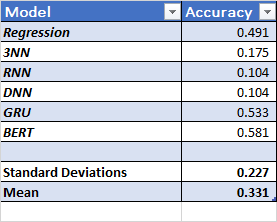

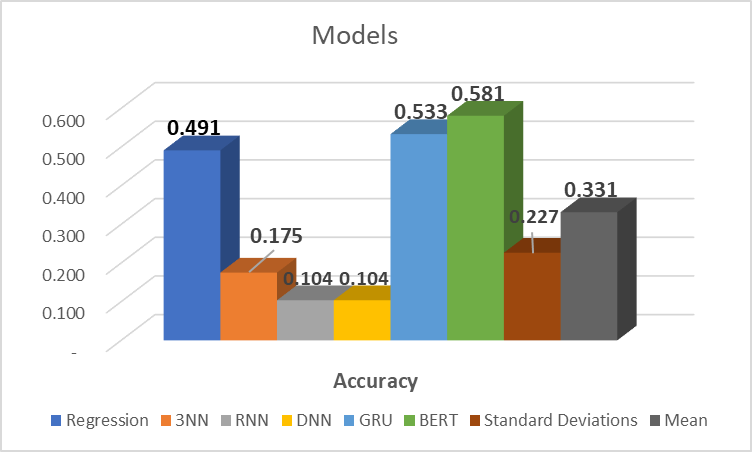

# Result:

After performing the given task, I clearly saw that the Bidirectional Encoder Representations from Transformer Model (BERT) outperformed all the other models I used. I would highly recommend using it because of its superior ability to understand the contextual meaning of words in a sentence and its efficiency in handling large datasets.

The models I would not recommend are the Recurrent Neural Networks Model (RNN) and Deep Neural Networks Model (DNN) due to their inefficient performance and their inability to effectively process my dataset.

The mean and standard deviation of all the models I tested are 0.331 and 0.227, respectively. Through my approach and learnings, I discovered the importance of a model's efficiency in managing sequential datasets that are large in volume. Additionally, it's crucial that the model executes the required task well and predicts outcomes accurately.

I experimented with various models, including the Logistic Regression Model, 3 Layers Neural Networks Model (CNN), Recurrent Neural Networks Model (RNN), Deep Neural Networks Model (DNN), Gated Recurrent Units (GRUs), and Bidirectional Encoder Representation from Transformer Model (BERT). Among these, I found that adjusting the number of epochs settings was challenging. I couldn't run the models as efficiently as I wanted due to Random Access Memory (RAM) and user interface limitations, particularly in Google Colab. Furthermore, I learned that increasing the number of epochs tended to improve the accuracy score. However, due to the mentioned limitations, I was unable to execute the models at the desired level of epochs, which prevented me from achieving optimum accuracy.


# Summary



In my analysis, the table I reviewed showcases the model and its respective accuracy, leading me to conclude that the Bidirectional Encoder Representations from Transformers (BERT) stands out. I can explain this as follows:

Firstly, BERT is incredibly adept at grasping the contextual meanings of words in sentences, from which it meticulously extracts useful features. Secondly, its capacity to process vast amounts of data allows me to efficiently train the dataset with BERT. Lastly, because BERT is pre-trained on extensive data collections, it effortlessly learns language patterns, which I can then fine-tune to perform any specific classification task.

After uploading the file on Kaggle, I achieved a score of 0.5808, which is decent considering I only set the training model to run for 2 epochs. However, I believe this could be significantly improved by increasing the number of epochs. This would likely enhance the accuracy score further. Therefore, I've observed that the number of epochs is directly proportional to the accuracy score. To achieve better results in the task, setting the epochs to a higher number, like 50, could potentially increase the score by approximately 20%.



### **#References: **
#www.w3school.com
#www.github.com
#www.stackoverflow.com
#www.geeksforgeeks.org
